# Colab Setup

In [0]:
!nvidia-smi

Wed Sep 25 11:06:33 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!pip install gdown --quiet

In [0]:
!pip install scikit-plot --quiet

In [0]:
!pip install tensorflow-gpu==2.0.0-beta1 --quiet

     |████████████████████████████████| 348.9MB 142kB/s 
     |████████████████████████████████| 3.1MB 46.1MB/s 
     |████████████████████████████████| 501kB 41.8MB/s 


# Imports and Data Setup

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import numpy as np
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path


from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation

from tensorflow.keras.layers import concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

from tensorflow.keras import backend
from tensorflow.keras.layers import Lambda

import tensorflow as tf

import gdown

import scikitplot as skplt

In [0]:
if tf.__version__[0] == '2':
    valacc = 'val_accuracy'
    acc = 'accuracy'
else:
    valacc = 'val_acc'
    acc = 'acc'

In [0]:
filenames = ['bak_chor_mee.zip', 'chicken_rice.zip', 'prata.zip']
file_urls = ['https://drive.google.com/uc?export=download&id=19dXCgO9UKyIUGULoGpAAI8ezRKbkMsBp',
             'https://drive.google.com/uc?export=download&id=1ALXrSoY2mKQt2eSjtZpCPma6_VlsNTM_',
             'https://drive.google.com/uc?export=download&id=1yyrkqxOqC2y1fw_HO095b7jMW86m0NQ6']

In [0]:
for filename, url in zip(filenames, file_urls):
    gdown.download(url, filename, quiet=False)

Downloading...
From: https://drive.google.com/uc?export=download&id=19dXCgO9UKyIUGULoGpAAI8ezRKbkMsBp
To: /content/bak_chor_mee.zip
275MB [00:01, 199MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1ALXrSoY2mKQt2eSjtZpCPma6_VlsNTM_
To: /content/chicken_rice.zip
250MB [00:01, 207MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1yyrkqxOqC2y1fw_HO095b7jMW86m0NQ6
To: /content/prata.zip
234MB [00:04, 55.8MB/s]


In [0]:
!unzip -qq bak_chor_mee.zip -d data/

In [0]:
!unzip -qq chicken_rice.zip -d data/

In [0]:
!unzip -qq prata.zip -d data/

In [0]:
Path.ls = lambda x: list(x.iterdir())

In [0]:
img_size = 160

In [0]:
batch_size = 32

In [0]:
num_classes=3

In [0]:
datapath = Path('./data')

In [0]:
datapath.ls()

[PosixPath('/content/data/bak_chor_mee'),
 PosixPath('/content/data/roti_prata'),
 PosixPath('/content/data/chicken_rice')]

## Setup data generators

In [0]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40, # Image Aug start
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2) # define validation pct

valid_datagen = ImageDataGenerator(rescale=1./255,
                                  validation_split = 0.2)

In [0]:
train_generator = train_datagen.flow_from_directory(
    datapath,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = valid_datagen.flow_from_directory(
    datapath, # same directory as training data
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = False,
    subset='validation') # set as validation data

Found 2746 images belonging to 3 classes.
Found 686 images belonging to 3 classes.


# Build Transfer Learning Model

In [0]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D

In [0]:
base_model = MobileNetV2(input_shape=(img_size,img_size,3),
                      include_top=False, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
modelname = 'tlmodel'

In [0]:
                            # Create checkpoint for the training
                            # This checkpoint performs model saving when
                            # an epoch gives highest testing accuracy
filepath        = modelname + ".hdf5"
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor=valacc, 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')

                            # Log the epoch detail into csv
csv_logger      = CSVLogger(modelname +'.csv')

callbacks_list  = [checkpoint,csv_logger]

In [0]:
model.fit_generator(train_generator, 
                    epochs=10,
                    steps_per_epoch = train_generator.samples // batch_size,
                    validation_data = validation_generator, 
                    validation_steps= validation_generator.samples // batch_size,
                    verbose = 1, 
                    max_queue_size=100,
                    callbacks=callbacks_list)

Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
55/85 [==================>...........] - ETA: 22s - loss: 1.0246 - accuracy: 0.5582

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  " Skipping tag %s" % (size, len(data), tag))


85/85 [==============================] - 76s 899ms/step - loss: 0.8975 - accuracy: 0.6139 - val_loss: 0.4207 - val_accuracy: 0.8289
Epoch 2/10
85/85 [==============================] - 75s 884ms/step - loss: 0.6147 - accuracy: 0.7421 - val_loss: 0.2978 - val_accuracy: 0.9003
Epoch 3/10
85/85 [==============================] - 74s 876ms/step - loss: 0.5197 - accuracy: 0.7911 - val_loss: 0.2699 - val_accuracy: 0.9048
Epoch 4/10
85/85 [==============================] - 75s 877ms/step - loss: 0.4835 - accuracy: 0.8040 - val_loss: 0.2686 - val_accuracy: 0.9033
Epoch 5/10
85/85 [==============================] - 74s 869ms/step - loss: 0.4697 - accuracy: 0.8055 - val_loss: 0.2550 - val_accuracy: 0.9018
Epoch 6/10
85/85 [==============================] - 73s 858ms/step - loss: 0.4662 - accuracy: 0.8147 - val_loss: 0.2570 - val_accuracy: 0.9048
Epoch 7/10
85/85 [==============================] - 72s 847ms/step - loss: 0.4020 - accuracy: 0.8419 - val_loss: 0.2681 - val_accuracy: 0.8899
Epoch 8/10

In [0]:
# need to replace later with test dir, new generator with only rescale
test_datagen = ImageDataGenerator(rescale=1./255,
                                  validation_split = 0.2)
test_generator = test_datagen.flow_from_directory(
    datapath, # same directory as training data
    target_size=(img_size, img_size),
    batch_size=1,
    shuffle=False,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 686 images belonging to 3 classes.


In [0]:
# Make classification on the test dataset
predicts = model.predict_generator(test_generator)

In [0]:
                            # Prepare the classification output
                            # for the classification report
predout = np.argmax(predicts, axis=1)
testout = test_generator.classes
labelname = list(test_generator.class_indices.keys())  

In [0]:
testScores  = metrics.accuracy_score(testout,predout)
print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))

Best accuracy (on testing dataset): 88.92%


In [0]:
confusion   = metrics.confusion_matrix(testout,predout)
print(confusion)

[[203  34   1]
 [ 10 223   3]
 [  1  27 184]]


In [0]:
print(metrics.classification_report(testout,predout,target_names=labelname,digits=4))

              precision    recall  f1-score   support

bak_chor_mee     0.9486    0.8529    0.8982       238
chicken_rice     0.7852    0.9449    0.8577       236
  roti_prata     0.9787    0.8679    0.9200       212

    accuracy                         0.8892       686
   macro avg     0.9042    0.8886    0.8920       686
weighted avg     0.9017    0.8892    0.8910       686



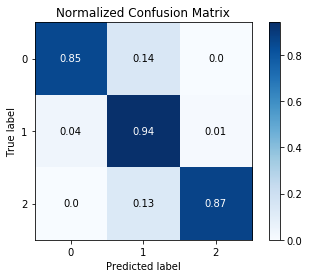

In [0]:
skplt.metrics.plot_confusion_matrix(testout, predout, normalize=True)

In [0]:
                            # Set up 'ggplot' style
plt.style.use('ggplot')     # if want to use the default style, set 'classic'
plt.rcParams['ytick.right']     = True
plt.rcParams['ytick.labelright']= True
plt.rcParams['ytick.left']      = False
plt.rcParams['ytick.labelleft'] = False
plt.rcParams['font.family']     = 'Arial'

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


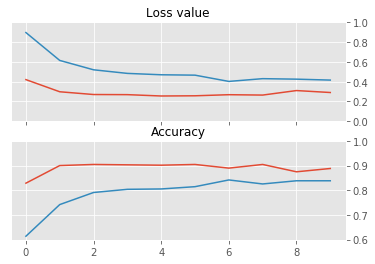

In [0]:
import pandas as pd

records     = pd.read_csv(modelname +'.csv')
plt.figure()
plt.subplot(211)
plt.plot(records['val_loss'])
plt.plot(records['loss'])
plt.yticks([0,0.20,0.40,0.60,0.80,1.00])
plt.title('Loss value',fontsize=12)

ax          = plt.gca()
ax.set_xticklabels([])



plt.subplot(212)
plt.plot(records[valacc])
plt.plot(records[acc])
plt.yticks([0.6,0.7,0.8,0.9,1.0])
plt.title('Accuracy',fontsize=12)
plt.show()

# Finetune Model

In [0]:
base_model.trainable = True

In [0]:
# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
modelname = 'tlmodel2'

In [0]:
                            # Create checkpoint for the training
                            # This checkpoint performs model saving when
                            # an epoch gives highest testing accuracy
filepath        = modelname + ".hdf5"
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor=valacc, 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')

                            # Log the epoch detail into csv
csv_logger      = CSVLogger(modelname +'.csv')

callbacks_list  = [checkpoint,csv_logger]

In [0]:
model.fit_generator(train_generator, 
                    epochs=10,
                    steps_per_epoch = train_generator.samples // batch_size,
                    validation_data = validation_generator, 
                    validation_steps= validation_generator.samples // batch_size,
                    verbose = 1, 
                    max_queue_size=100,
                    callbacks=callbacks_list)

Epoch 1/10
71/85 [========================>.....] - ETA: 12s - loss: 0.4177 - accuracy: 0.8653

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  " Skipping tag %s" % (size, len(data), tag))


85/85 [==============================] - 87s 1s/step - loss: 0.4054 - accuracy: 0.8648 - val_loss: 1.9666 - val_accuracy: 0.7634
Epoch 2/10
85/85 [==============================] - 79s 927ms/step - loss: 0.2621 - accuracy: 0.9116 - val_loss: 1.2556 - val_accuracy: 0.8318
Epoch 3/10
85/85 [==============================] - 78s 917ms/step - loss: 0.2092 - accuracy: 0.9344 - val_loss: 2.8468 - val_accuracy: 0.6786
Epoch 4/10
85/85 [==============================] - 79s 931ms/step - loss: 0.1679 - accuracy: 0.9425 - val_loss: 6.8796 - val_accuracy: 0.4866
Epoch 5/10
85/85 [==============================] - 81s 951ms/step - loss: 0.1663 - accuracy: 0.9495 - val_loss: 0.5582 - val_accuracy: 0.9107
Epoch 6/10
85/85 [==============================] - 78s 913ms/step - loss: 0.1460 - accuracy: 0.9539 - val_loss: 5.5327 - val_accuracy: 0.6280
Epoch 7/10
85/85 [==============================] - 78s 914ms/step - loss: 0.1581 - accuracy: 0.9499 - val_loss: 3.5092 - val_accuracy: 0.6280
Epoch 8/10
85

In [0]:
from tensorflow.keras.models import model_from_json
with open('tlmodel2_arch.json', 'w') as f:
    f.write(model.to_json())

# Test Fine-tuned Model

In [0]:
with open('tlmodel2_arch.json', 'r') as f:
    modelGo = model_from_json(f.read())

# Load weights into the new model
filepath = 'tlmodel2.hdf5'
modelGo.load_weights(filepath)

In [0]:
modelGo.compile(loss='categorical_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy'])

In [0]:
predicts = modelGo.predict_generator(test_generator)

In [0]:
                            # Prepare the classification output
                            # for the classification report
predout = np.argmax(predicts, axis=1)
testout = test_generator.classes
labelname = list(test_generator.class_indices.keys())  

In [0]:
testScores  = metrics.accuracy_score(testout,predout)
print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))

Best accuracy (on testing dataset): 92.42%


In [0]:
confusion   = metrics.confusion_matrix(testout,predout)
print(confusion)

[[209  17  12]
 [  8 222   6]
 [  1   8 203]]


In [0]:
print(metrics.classification_report(testout,predout,target_names=labelname,digits=4))

              precision    recall  f1-score   support

bak_chor_mee     0.9587    0.8782    0.9167       238
chicken_rice     0.8988    0.9407    0.9193       236
  roti_prata     0.9186    0.9575    0.9376       212

    accuracy                         0.9242       686
   macro avg     0.9254    0.9255    0.9245       686
weighted avg     0.9257    0.9242    0.9240       686



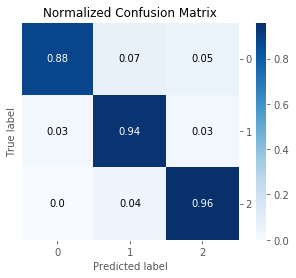

In [0]:
skplt.metrics.plot_confusion_matrix(testout, predout, normalize=True)

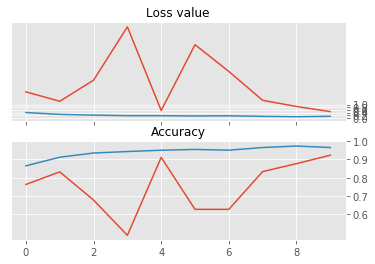

In [0]:
import pandas as pd

records     = pd.read_csv(modelname +'.csv')
plt.figure()
plt.subplot(211)
plt.plot(records['val_loss'])
plt.plot(records['loss'])
plt.yticks([0,0.20,0.40,0.60,0.80,1.00])
plt.title('Loss value',fontsize=12)

ax          = plt.gca()
ax.set_xticklabels([])



plt.subplot(212)
plt.plot(records[valacc])
plt.plot(records[acc])
plt.yticks([0.6,0.7,0.8,0.9,1.0])
plt.title('Accuracy',fontsize=12)
plt.show()